In [1]:
from dotenv import load_dotenv

load_dotenv()

True

#### Creating VectorDatabase

In [2]:
from langchain.schema import Document
from typing import TypedDict, Optional, Dict, Any
from datetime import datetime
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

docs = [
    Document(
        page_content="The Indian Premier League (IPL) is a professional Twenty20 cricket league in India, founded by the Board of Control for Cricket in India (BCCI) in 2008. It is one of the most popular and lucrative cricket leagues in the world.",
        metadata={"source": "ipl_info.txt"},
    ),
    Document(
        page_content="The IPL features ten teams representing different cities in India. Each team is owned by franchises and competes in a round-robin format, followed by playoffs and a final to determine the champion.",
        metadata={"source": "ipl_info.txt"},
    ),
    Document(
        page_content="Some of the most successful IPL teams include Mumbai Indians, Chennai Super Kings, and Kolkata Knight Riders. These teams have won multiple titles and have a strong fan following.",
        metadata={"source": "ipl_info.txt"},
    ),
    Document(
        page_content="The IPL has produced many thrilling matches and iconic moments, including last-over finishes, record-breaking individual performances, and intense rivalries between teams.",
        metadata={"source": "ipl_info.txt"},
    ),
]


db = Chroma.from_documents(docs, embedding_function)

retriever = db.as_retriever()

In [3]:
from typing_extensions import TypedDict


class AgentState(TypedDict):
    question: str
    grades: list[str]
    llm_output: str
    documents: list[str]
    on_topic: bool
   

In [4]:
def retrieve_docs(state: AgentState):
    question = state["question"]
    documents = retriever.get_relevant_documents(query=question)
    state["documents"] = [doc.page_content for doc in documents]
    return state

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq


class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is releated to the IPL"""

    score: str = Field(
        description="Question is about IPL? If yes -> 'Yes' if not -> 'No'"
    )


def question_classifier(state: AgentState):
    question = state["question"]

    system = """You are a grader assessing the relevance of a retrieved document to a user question. 
        Only answer if the question is about one of the following topics:
        1. General information about the Indian Premier League (IPL).
        2. Teams participating in the IPL.
        3. Successful IPL teams and their achievements.
        4. Iconic moments and thrilling matches in IPL history.

        If the question IS about these topics, respond with "Yes", otherwise respond with "No".
        """


    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = ChatGroq(groq_api_key="",model_name="Gemma2-9b-It")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    state["on_topic"] = result.score
    return state

c:\LLM\venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
def on_topic_router(state: AgentState):
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"

In [7]:
def off_topic_response(state: AgentState):
    state["llm_output"] = "I cant respond to that!"
    return state

In [ ]:
class GradeDocuments(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(
        description="Documents are relevant to the question, 'Yes' or 'No'"
    )


def document_grader(state: AgentState):
    docs = state["documents"]
    question = state["question"]

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    llm = ChatGroq(groq_api_key="",model_name="Gemma2-9b-It")
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm
    scores = []
    for doc in docs:
        result = grader_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)
    state["grades"] = scores
    return state

In [9]:
def gen_router(state: AgentState):
    grades = state["grades"]
    print("DOCUMENT GRADES:", grades)

    if any(grade.lower() == "yes" for grade in grades):
        filtered_grades = [grade for grade in grades if grade.lower() == "yes"]
        print("FILTERED DOCUMENT GRADES:", filtered_grades)
        return "generate"
    else:
        return "rewrite_query"

In [ ]:
from langchain_core.output_parsers import StrOutputParser


def rewriter(state: AgentState):
    question = state["question"]
    system = """You a question re-writer that converts an input question to a better version that is optimized \n
        for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    llm = ChatGroq(groq_api_key="",model_name="Gemma2-9b-It")
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    state["question"] = output
    return state

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser


def generate_answer(state: AgentState):
    llm = ChatGroq(groq_api_key="",model_name="Gemma2-9b-It")
    question = state["question"]
    context = state["documents"]

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template,
    )
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": context})
    state["llm_output"] = result
    return state

In [12]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)

workflow.add_edge("off_topic_response", END)
workflow.add_edge("retrieve_docs", "document_grader")
workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response",
    },
)
workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
    },
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)


workflow.set_entry_point("topic_decision")

app = workflow.compile()

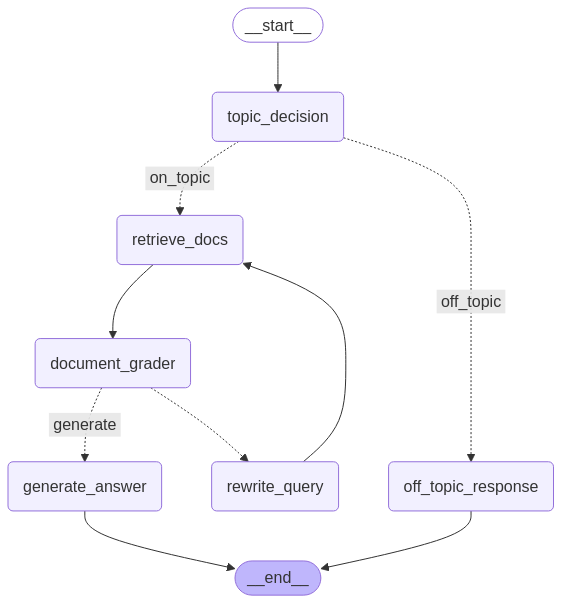

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [14]:
result = app.invoke({"question": "How is the weather?"})
result["llm_output"]

'I cant respond to that!'

In [15]:
result = app.invoke({"question": "what is IPL??"})
result["llm_output"]

C:\Users\amans\AppData\Local\Temp\ipykernel_27656\336059196.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents = retriever.get_relevant_documents(query=question)


DOCUMENT GRADES: ['Yes', 'Yes', 'Yes', 'No']
FILTERED DOCUMENT GRADES: ['Yes', 'Yes', 'Yes']


'The Indian Premier League (IPL) is a professional Twenty20 cricket league in India. \n'